In [70]:
from CoRe_Dataloader_ECSG import load_raw_from_pth_file
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
spectrograms, parameters = load_raw_from_pth_file()

In [23]:
tbc = []
for sgram, param in zip(spectrograms,parameters):
    param = param.cpu().numpy()
    map(lambda x: x.cpu().item(), param)
    sgram = sgram.cpu()
    sgram = sgram.numpy()
    tbc.append(pd.DataFrame([sgram,*param]).T)
combined = pd.concat(tbc)
combined

C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0,1,2,3
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12.0,1.349968,1.349968
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.0,1.350608,1.350608
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.0,1.375004,1.375004
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14.0,1.350868,1.350868
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.0,1.4,1.4
...,...,...,...,...
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13.0,1.249905,1.450058
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14.0,1.500016,1.000001
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.0,1.800159,0.900063
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",10.0,1.650017,1.100006


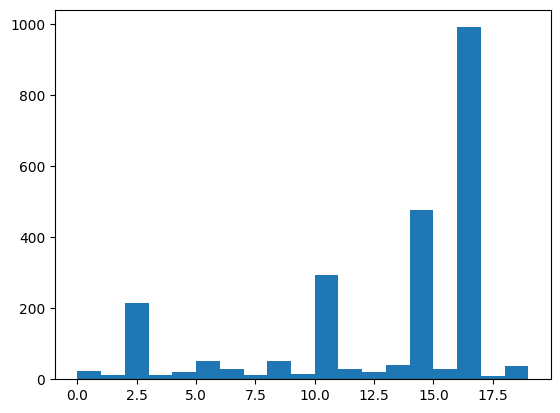

In [44]:
pltdata = plt.hist(combined[1],bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

In [48]:
freq = pltdata[0]
eos = pltdata[1]


In [49]:
for i,j in zip(eos,freq):
    print(i,j)

0 24.0
1 12.0
2 215.0
3 13.0
4 20.0
5 52.0
6 29.0
7 11.0
8 52.0
9 16.0
10 293.0
11 28.0
12 21.0
13 39.0
14 475.0
15 30.0
16 990.0
17 9.0
18 36.0


In [60]:
sixteens = combined[combined[1] == 16]
fourteens = combined[combined[1] == 14]
tens = combined[combined[1] == 10]
twos = combined[combined[1] == 2]
others = combined[~combined[1].isin([16,14,10,2])]


In [64]:
fivetypes = [sixteens,fourteens,tens,twos,others]
sixteens.loc[:, 1] = 0
fourteens.loc[:, 1] = 1
tens.loc[:, 1] = 2
twos.loc[:, 1] = 3
others.loc[:, 1] = 4


C:\Users\aashr\AppData\Local\Temp\ipykernel_35316\1821812001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sixteens.loc[:, 1] = 0
C:\Users\aashr\AppData\Local\Temp\ipykernel_35316\1821812001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourteens.loc[:, 1] = 1
C:\Users\aashr\AppData\Local\Temp\ipykernel_35316\1821812001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 